In [1]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### Create dataset path root for the train and validation datas.

In [12]:
train_dir = os.path.join(path="C:/Users/murat/Documents/tensorflow/datasets/standard_ocr_dataset/data/training_data")
test_dir = os.path.join(path="C:/Users/murat/Documents/tensorflow/datasets/standard_ocr_dataset/data/testing_data")

In [92]:
BATCH_SIZE = 36
IMG_SIZE = (36, 36)

train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 20628 files belonging to 36 classes.
Found 1008 files belonging to 36 classes.


In [93]:
class_names = train_ds.class_names
class_names

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

#### Show the first nine images and labels from the training set:

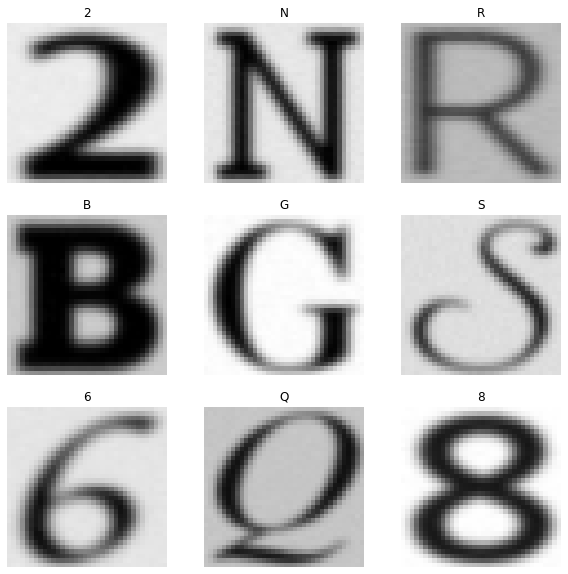

In [94]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X=images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Create a test dataset

In [95]:
validation_batches = tf.data.experimental.cardinality(dataset=validation_ds)
test_ds = validation_ds.take(validation_batches // 5)
validation_dataset = validation_ds.skip(validation_batches // 5)

In [96]:
print(f"Number of validation batches: {tf.data.experimental.cardinality(validation_dataset)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Number of validation batches: 23
Number of test batches: 5


#### Keep the dataset on the ram for configure the dataset for performance

In [97]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation for the generalizable model

In [98]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

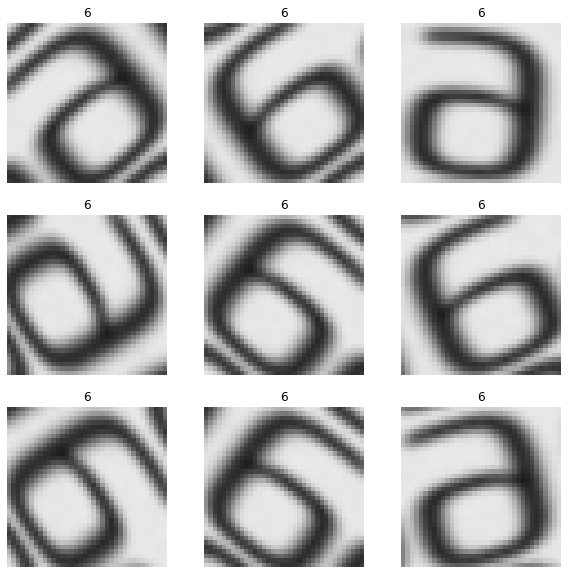

In [99]:
for image, label in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    label = class_names[label[0]]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(X=augmented_image[0] / 255)
        plt.title(label)
        plt.axis("off")

#### Rescale pixel values

In [100]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.src.applications.mobilenet_v2.preprocess_input(x, data_format=None)>

In [101]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)
rescale

#### Create the base model from the pre-trained convnets

In [102]:
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

base_model = tf.keras.applications.MobileNetV2(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = "imagenet"
)

(36, 36)
(36, 36, 3)


In [103]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(36, 2, 2, 1280)


#### Freeze the convolutional base

In [104]:
base_model.trainable = False

#### Add a classification head

In [105]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(36, 1280)


In [106]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(36, 1)


#### Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the "Keras Functional API"

In [107]:
inputs = tf.keras.Input(shape=(36, 36, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

In [108]:
base_learning_rate = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [109]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 36, 36, 3)         0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 36, 36, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 36, 36, 3)         0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                           

In [110]:
len(model.trainable_variables)

2

#### Train the model

In [111]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_ds)

print(f"initial loss: {loss0:.2f}")
print(f"initial accuracy: {accuracy0:.2f}")

28/28 [==============================] - 2s 31ms/step - loss: -7.0067 - accuracy: 0.0288
initial loss: -7.01
initial accuracy: 0.03


In [112]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
573/573 [==============================] - 27s 45ms/step - loss: -2215.6187 - accuracy: 0.0278 - val_loss: -4314.0801 - val_accuracy: 0.0278
Epoch 2/10
573/573 [==============================] - 20s 35ms/step - loss: -6669.8066 - accuracy: 0.0278 - val_loss: -8644.2637 - val_accuracy: 0.0278
Epoch 3/10
573/573 [==============================] - 21s 36ms/step - loss: -11109.6270 - accuracy: 0.0278 - val_loss: -12956.5693 - val_accuracy: 0.0278
Epoch 4/10
573/573 [==============================] - 21s 36ms/step - loss: -15476.0508 - accuracy: 0.0278 - val_loss: -17265.7617 - val_accuracy: 0.0278
Epoch 5/10
573/573 [==============================] - 20s 35ms/step - loss: -19918.3027 - accuracy: 0.0278 - val_loss: -21573.2949 - val_accuracy: 0.0278
Epoch 6/10
573/573 [==============================] - 21s 36ms/step - loss: -24448.7422 - accuracy: 0.0278 - val_loss: -25906.6328 - val_accuracy: 0.0278
Epoch 7/10
573/573 [==============================] - 20s 35ms/step - loss: -287

#### Learning Curves

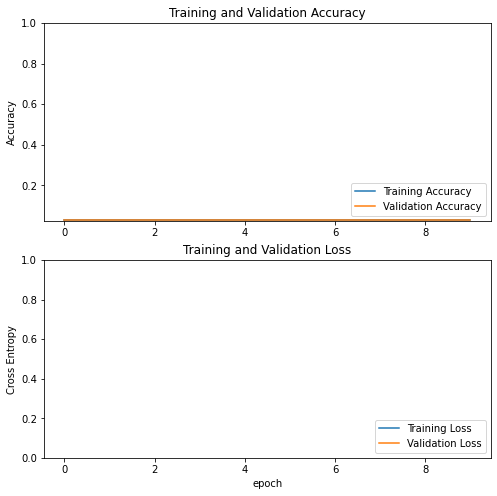

In [114]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), 1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show();

#### Un-freeze the top layers of the model

In [115]:
base_model.trainable = True

In [116]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  154


#### Compile the model

In [117]:
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=["accuracy"]
)

In [118]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 36, 36, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 36, 36, 3)         0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 36, 36, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 36, 36, 3)         0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                           

In [119]:
len(model.trainable_variables)

56

#### Continue training the model

In [120]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data = validation_dataset
)

Epoch 10/20
573/573 [==============================] - 32s 51ms/step - loss: -545436.0000 - accuracy: 0.0278 - val_loss: -550539.3125 - val_accuracy: 0.0278
Epoch 11/20
573/573 [==============================] - 32s 57ms/step - loss: -554052.8750 - accuracy: 0.0278 - val_loss: -557725.3750 - val_accuracy: 0.0278
Epoch 12/20
573/573 [==============================] - 34s 59ms/step - loss: -561305.3125 - accuracy: 0.0278 - val_loss: -564909.4375 - val_accuracy: 0.0278
Epoch 13/20
573/573 [==============================] - 34s 59ms/step - loss: -568543.8125 - accuracy: 0.0278 - val_loss: -572095.8125 - val_accuracy: 0.0278
Epoch 14/20
573/573 [==============================] - 34s 59ms/step - loss: -575705.0625 - accuracy: 0.0278 - val_loss: -579282.3750 - val_accuracy: 0.0278
Epoch 15/20
573/573 [==============================] - 34s 60ms/step - loss: -582826.0000 - accuracy: 0.0278 - val_loss: -586469.1875 - val_accuracy: 0.0278
Epoch 16/20
573/573 [==============================] - 33s

#### Evaluation and prediction

In [121]:
loss, accuracy = model.evaluate(test_dataset)
print("Test Accuracy: ", accuracy)

5/5 [==============================] - 0s 27ms/step - loss: -564142.1250 - accuracy: 0.0389
Test Accuracy:  0.03888889029622078


#### And now we are all set to use this model to predict if true chrachter is 

In [147]:
#os.listdir(path=f"{test_dir}/0")[0]
pred_path = f"{test_dir}/0/28310.png"

img = tf.keras.utils.load_img(pred_path, target_size=IMG_SIZE)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100*np.max(score):.2f} percent confidence.")

1/1 [==============================] - 0s 17ms/step
This image most likely belongs to 0 with a 100.00 percent confidence.
